# **Laboratorio 1**
**Daniela Navas**

## **Task 1** - Regresión Lineal

**1. Considera un modelo de regresión lineal con dos características, X₁ y X₂, y sus pesos correspondientes w₁ y w₂. Si el modelo predice una salida y mediante la ecuación y = 2w₁X₁ + 3w₂X₂ + 1, ¿cuál es la interpretación del coeficiente 3w₂ en el contexto del modelo?**<br>
Explica el efecto que tiene la variable X₂ en la salida y, al ser positivo indica que la subida del párametro w₂ implica una subida en la salida, es decir, directamente proporional. Estar multiplicado por un factor de 3, sugiere que el efecto de X₂ es sobre y y es tres veces más fuerte que el efecto de por w₂ sí solo.


**2. Explica el concepto de multicolinealidad en el contexto de la regresión lineal. ¿Cómo afecta la multicolinealidad a la interpretación de los coeficientes de regresión individuales?**<br>
La multicolinealidad ocurre en un modelo de regresión lineal cuando dos o más variables independientes están altamente correlacionadas entre sí. Esto significa que una variable puede ser predicha con precisión por las demás variables independientes en el modelo. La multicolinealidad puede causar que los coeficientes de regresión tengan grandes varianzas. Esto significa que pequeños cambios en los datos pueden resultar en cambios significativos en los coeficientes estimados, lo que dificulta su interpretación. Debido a que las variables están altamente correlacionadas, es difícil determinar el efecto específico de cada variable sobre la variable dependiente. Los coeficientes pueden no reflejar con precisión la relación real entre cada variable independiente y la variable dependiente.

## **Task 2** - Clasificación de Sitios de Phishing Regresión Logística y KNN
### **Exploración de Datos**

La base de datos consiste en 89 variables y 11429 observaciones. De las cuales, la primera variable indica el URL y la última indica si el sitio es *legitimate* o *phishing* que es lo que se trata determinar con los modelos generados. Por ende, hay un total de 87 variables que se pueden usar para dentro del modelo. En esta primera parte se explora la base de datos para aplicar procesos de limpieza y definir que variables serán de utilidad para los modelos. 

La base está balanceada con un 50% de datos *legitimate* y un 50% de datos *phishing*, además se revisan todas las observaciones determinando que no hay ninguna con datos vacíos o incompletos, por ende no es necesario eliminar ninguna observación.

In [1]:
# Importar librerias
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Importar base de datos
dataset_phishing = pd.read_csv('dataset_phishing.csv', delimiter=",", header='infer')

# Analizar estructura y resumen de bases de datos
# print(str(dataset_phishing))
# print(dataset_phishing.describe())

# Revisar la distribución de las clases
print("Distribución de las clases:")
print(dataset_phishing['status'].value_counts())  
print("-----------------------------------------------------")

# Revisar que todas las observaciones tengan la cantidad adecuada de variables (89 de acuerdo a la documentación)
column_length = len(dataset_phishing.columns)

# Filtrar las filas con el número adecuado de columnas
valid_rows = dataset_phishing[dataset_phishing.apply(lambda row: len(row) == column_length, axis=1)]

# Contar cuántas filas fueron eliminadas
rows_deleted = len(dataset_phishing) - len(valid_rows)

print("Cantidad de observaciones con variables incompletas: ")
print(rows_deleted)
print("-----------------------------------------------------")

# Eliminar las filas con variables incompletas
dataset_phishing = valid_rows

Distribución de las clases:
status
legitimate    5715
phishing      5715
Name: count, dtype: int64
-----------------------------------------------------
Cantidad de observaciones con variables incompletas: 
0
-----------------------------------------------------


Ahora, se convierte la última variable "*status*" en 0 para sitios *legitimate* y 1 para sitios *phishing* lo que es necesario para aplicar el modelo de regresión lógistica, donde la variable de salida debe ser númerica.

In [2]:
# Convertir variable "status" en 0 para sitios legitimate y 1 para sitios phishing
dataset_phishing['status'] = dataset_phishing['status'].replace({'legitimate': 0, 'phishing': 1})

# Revisar la distribución de las clases nuevamente
print("Distribución de las clases (Nuevamente):")
print(dataset_phishing['status'].value_counts())  
print("-----------------------------------------------------")

Distribución de las clases (Nuevamente):
status
0    5715
1    5715
Name: count, dtype: int64
-----------------------------------------------------


C:\Users\Daniela\AppData\Local\Temp\ipykernel_12864\2826216094.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset_phishing['status'] = dataset_phishing['status'].replace({'legitimate': 0, 'phishing': 1})


Se realiza una división de la base de datos para training y testing, en una proporción 80-20, respectivamente. Además, se revisa que la distribución en la bases de training y testing en las clases, comprobando que siga estando balanceada.

In [3]:
# Dividir en 80% training y 20% testing
train_set, test_set = train_test_split(dataset_phishing, test_size=0.2, random_state=42)

# Verificar las dimensiones de los conjuntos resultantes
print(f"Dimesiones Data Training (80%): {train_set.shape}")
print(f"Dimesiones Data Testing (20%): {test_set.shape}")
print("-----------------------------------------------------")

print("Distribución de las clases Data Training:")
print(train_set['status'].value_counts())  
print("-----------------------------------------------------")

print("Distribución de las clases Data Testing:")
print(test_set['status'].value_counts())  
print("-----------------------------------------------------")

Dimesiones Data Training (80%): (9144, 89)
Dimesiones Data Testing (20%): (2286, 89)
-----------------------------------------------------
Distribución de las clases Data Training:
status
1    4586
0    4558
Name: count, dtype: int64
-----------------------------------------------------
Distribución de las clases Data Testing:
status
0    1157
1    1129
Name: count, dtype: int64
-----------------------------------------------------


A modo de ejemplificación se grafican algunas de las variables que pueden ser usadas dentro del modelo de regresión logística para asegurar que esten en un estado óptimo para ser usadas.

<Axes: xlabel='nb_slash', ylabel='status'>

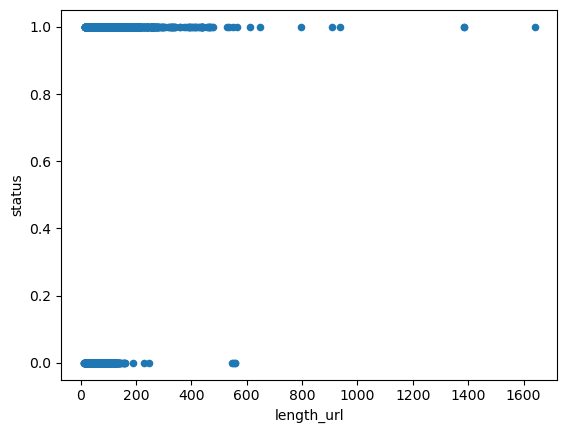

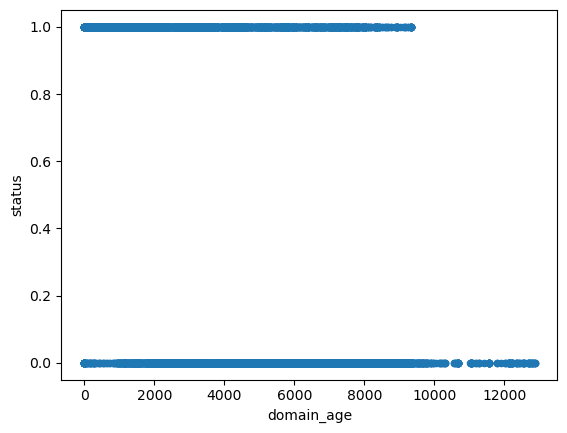

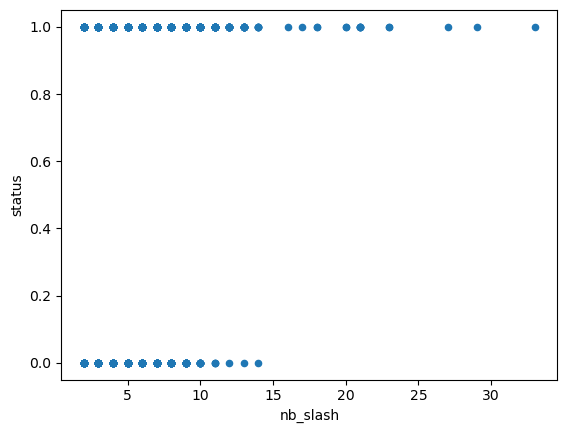

In [4]:
train_set[['length_url','status']].plot.scatter(x='length_url', y='status')
train_set[['domain_age','status']].plot.scatter(x='domain_age', y='status')
train_set[['nb_slash','status']].plot.scatter(x='nb_slash', y='status')

### **Task 2.1** - Regresión Logística
Implementar desde cero el algoritmo de Regresión Logística. Para ello, primero se define la Función Sigmoide, la Función de Costo y el Gradiente Descendente.

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Función sigmoide
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Función de costo
def compute_cost(X, y, theta):
    m = len(y)  # Número de muestras
    h = sigmoid(np.dot(X, theta))  # Predicciones
    cost = -(1 / m) * (np.dot(y, np.log(h)) + np.dot(1 - y, np.log(1 - h)))
    return cost

# Gradiente descendente
def gradient_descent(X, y, theta, learning_rate, epochs):
    m = len(y)  # Número de muestras
    cost_history = []  # Guardar evolución del costo

    for i in range(epochs):
        h = sigmoid(np.dot(X, theta))  # Predicciones
        gradient = (1 / m) * np.dot(X.T, h - y)  # Gradiente
        theta -= learning_rate * gradient  # Actualizar parámetros
        cost = compute_cost(X, y, theta)  # Calcular costo
        cost_history.append(cost)
    return theta, cost_history

Se definen los set de datos para el modelo logísitco, para ello, se decide usar las variables que son de tipo *int* y *float* y que además no todas sus observaciones son iguales a 0. Asimismo, se realiza un proceso de normalización para mejorar la eficiencia del modelo, se inicializan parámetros de theta, learning rate y epochs.

In [6]:
# Cargar los datos escogiendo las variables adecuadas 
X_train = train_set.iloc[:, [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 57, 58, 59, 61, 63, 65, 68, 70, 71, 75, 82, 83]].values  # Seleccionar la característica deseada
y_train = train_set['status'].values  # Etiqueta objetivo

# Normalizar los datos
X_mean = np.mean(X_train, axis=0)
X_std = np.std(X_train, axis=0)
X_train = (X_train - X_mean) / X_std

# Agregar una columna de unos para el sesgo
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

# Inicializar parámetros de theta, learning rate y epochs
theta = np.zeros(X_train.shape[1])  # Inicializar en ceros
learning_rate = 0.1  # Tasa de aprendizaje
epochs = 1000  # Iteraciones

Se entrena el modelo con los parámetros definidos usando el set de datos de train y se visualizan los resultados de costo, contra iteraciones. 

C:\Users\Daniela\AppData\Local\Temp\ipykernel_12864\1995752678.py:12: RuntimeWarning: divide by zero encountered in log
  cost = -(1 / m) * (np.dot(y, np.log(h)) + np.dot(1 - y, np.log(1 - h)))


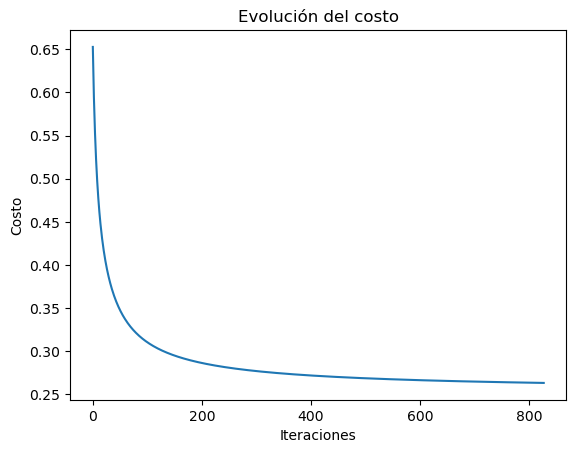

In [7]:
# Entrenar el modelo
optimal_theta, cost_history = gradient_descent(X_train, y_train, theta, learning_rate, epochs)

# Visualización del costo (opcional)
plt.plot(cost_history)
plt.title("Evolución del costo")
plt.xlabel("Iteraciones")
plt.ylabel("Costo")
plt.show()

Usando el modelo con el set de datos test, se extraen las variables definidas y se evalua el rendimiento del modelo logísitco definido. Se emplean como métricas de desempeño la precisión, sensibilidad y especificidad por medio de la Matriz de confusión, esto porque son directamente relevantes para evaluar el desempeño en problemas de clasificación binaria, ya que ofrecen una interpretación intuitiva y permiten evaluar diferentes aspectos del rendimiento del modelo. Además, son especialmente útiles en aplicaciones donde el costo de errores de tipo I o II es significativo.


Matriz de confusión:
TP: 991, FP: 106
FN: 138, TN: 1051
------------------------------------------
Precisión: 89.32633420822397 %
Sensibilidad: 87.77679362267493  %
Especificidad: 90.83837510803802  %


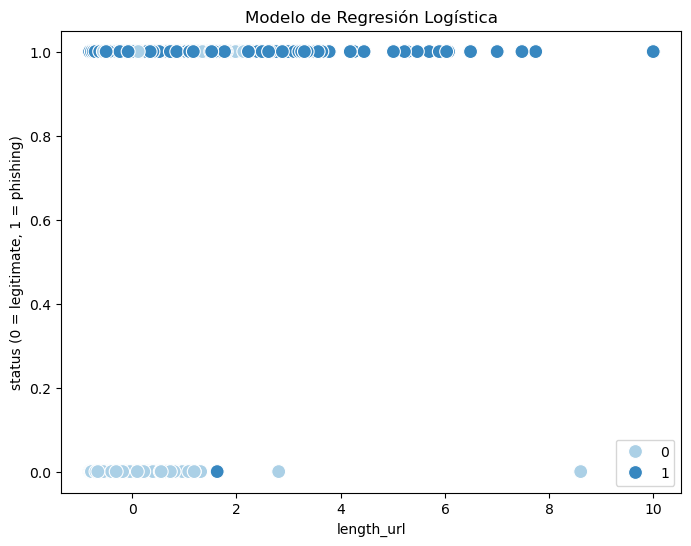

In [8]:
# Probar el modelo con test_set
X_test = test_set.iloc[:, [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 57, 58, 59, 61, 63, 65, 68, 70, 71, 75, 82, 83]].values  # Seleccionar la característica deseada del conjunto de prueba
y_test = test_set['status'].values  # Etiqueta objetivo del conjunto de prueba

# Normalizar las características del conjunto de prueba
X_test = (X_test - X_mean) / X_std
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))  # Agregar columna de unos

# Predicciones en el conjunto de prueba
predictions = sigmoid(np.dot(X_test, optimal_theta))

# Umbral para clasificar como 0 o 1
predictions = (predictions >= 0.5).astype(int)

# Matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
# Mostrar la matriz de confusión
print("\nMatriz de confusión:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")
print("------------------------------------------")

# Calcular sensibilidad y especificidad
sensitivity = tp / (tp + fn)  # Verdaderos positivos / Total positivos reales
specificity = tn / (tn + fp)  # Verdaderos negativos / Total negativos reales

# Métrica de desempeño: Precisión
accuracy = np.mean(predictions == y_test) * 100
print("Precisión:", accuracy, "%")
print("Sensibilidad:", sensitivity*100, " %")
print("Especificidad:", specificity*100, " %")

import seaborn as sns
# Selecciona una variable para gráficar contra status
x = X_test[:, 1]  # Selecciona la segunda columna de características (puedes cambiarlo según lo que necesites)
y = y_test  # Etiquetas verdaderas

# Crear un gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=predictions, palette="Blues", s=100)
plt.title('Modelo de Regresión Logística')
plt.xlabel('length_url')
plt.ylabel('status (0 = legitimate, 1 = phishing)')
plt.show()


Por medio de ello, se puede definir que el modelo tiene:<br>
- **Precisión:** 89.32% <br>
- **Sensibilidad:** 87.78% <br>
- **Especificidad:** 90.82% <br>

Estos resultados indican que el 89.32% de las predicciones fueron correctas, el modelo identificó correctamente el 87.78% de los casos positivos y el 90.82% de los casos negativos. Estos resultados se pueden considerar buenos, ya que indican un alto nivel de precisión general y una buena capacidad para identificar tanto casos positivos como negativos. 

---
Implementar el modelo usando **librerías**, para ello se importa sklearn. Con ello se puede crear el modelo y usar las mismas métricas de rendimiento para comparar con el modelo anterior.


Matriz de confusión:
TP: 1004, FP: 109
FN: 125, TN: 1048
------------------------------------------
Precisión: 89.76377952755905 %
Sensibilidad: 88.92825509300266  %
Especificidad: 90.5790838375108  %


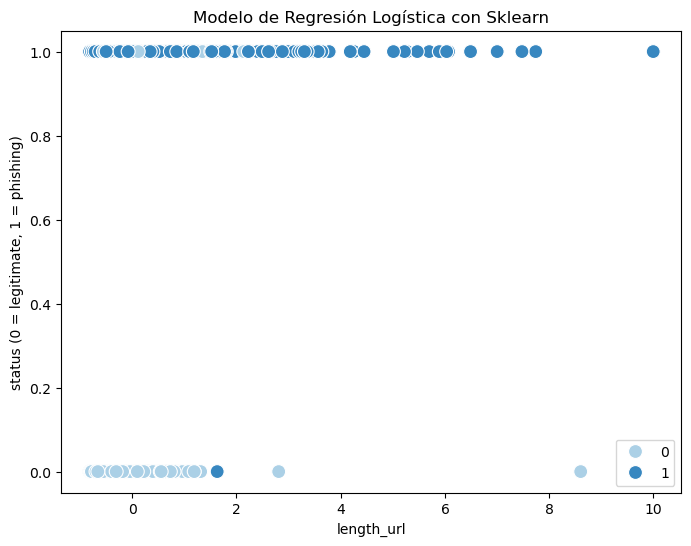

In [9]:
# Importar las librerías necesarias
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Ya previamente se definieron X_train, y_train, X_test y y_test por eso no se redefinen 

# Crear el modelo de regresión logística
model = LogisticRegression(max_iter=1000)  # Ajustamos 'max_iter' si es necesario, dependiendo de los datos

# Entrenar el modelo con el conjunto de entrenamiento
model.fit(X_train, y_train)

# Hacer predicciones sobre el conjunto de prueba
y_pred = model.predict(X_test)

# Matriz de confusión
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Mostrar la matriz de confusión
print("\nMatriz de confusión:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")
print("------------------------------------------")

# Calcular sensibilidad y especificidad
sensitivity = tp / (tp + fn)  # Verdaderos positivos / Total positivos reales
specificity = tn / (tn + fp)  # Verdaderos negativos / Total negativos reales

# Métrica de desempeño: Precisión
accuracy = np.mean(y_pred == y_test) * 100
print("Precisión:", accuracy, "%")
print("Sensibilidad:", sensitivity * 100, " %")
print("Especificidad:", specificity * 100, " %")

# Seleccionar una variable para graficar
x = X_test[:, 1]  # Selecciona la segunda columna de características (ajustar según lo que necesites)
y = y_test  # Etiquetas verdaderas

# Crear un gráfico de dispersión
plt.figure(figsize=(8, 6))
sns.scatterplot(x=x, y=y, hue=y_pred, palette="Blues", s=100)
plt.title('Modelo de Regresión Logística con Sklearn')
plt.xlabel('length_url')  # Cambia el nombre de la columna según corresponda
plt.ylabel('status (0 = legitimate, 1 = phishing)')
plt.show()


Por medio de ello, se puede definir que el modelo con libreria tiene:<br>
- **Precisión:** 89.76% <br>
- **Sensibilidad:** 88.93% <br>
- **Especificidad:** 90.58% <br>

Estos resultados indican que el 89.76% de las predicciones fueron correctas, el modelo identificó correctamente el 87.93% de los casos positivos y el 90.58% de los casos negativos. Estos resultados se pueden considerar buenos, ya que indican un alto nivel de precisión general y una buena capacidad para identificar tanto casos positivos como negativos. 

---

**¿Cuál implementación fue mejor? ¿Por qué?**<br>
Se observa que el modelo con librería tiene una precisión ligeramente superior (89.76% vs 89.32%) y una sensibilidad también ligeramente mejor (88.93% vs 87.78%). Sin embargo, el modelo realizado desde cero tiene una especificidad ligeramente superior (90.82% vs 90.58%). En general, el modelo con librería parece ser mejor debido a su mayor precisión y sensibilidad. Esto se debe probablemente a que las librerías están optimizadas para manejar grandes conjuntos de datos y suelen incluir técnicas avanzadas de regularización o selección de características que mejoran el rendimiento general. Además, las librerías están más probadas y pueden ser más estables en diferentes escenarios, lo que reduce la posibilidad de errores de implementación.

### **Task 2.2** - K-Nearest Neighbors 
Implementar desde cero el algoritmo de K-Nearest Neighbors . Para ello, primero se define la función para la distancia eucladiana, la implementación del KNN y medir las métricas de rendimiento, al igual que en el modelo logístico se utiliza presición, sensibilidad y especificidad.


In [189]:
# Importación de Librerias
import math
import matplotlib.pyplot as plt
from collections import Counter

# Función para calcular la distancia Euclidiana
def euclidean_distance(point1, point2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(point1, point2)))

# Implementación de KNN
class KNearestNeighbors:
    def __init__(self, k=3):
        self.k = k  # Número de vecinos más cercanos

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return predictions

    def _predict(self, x):
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train] # Calcular las distancias entre el punto de test 'x' y todos los puntos de entrenamiento
        k_indices = sorted(range(len(distances)), key=lambda i: distances[i])[:self.k] # Obtener los índices de los K puntos más cercanos
        k_nearest_labels = [self.y_train[i] for i in k_indices] # Obtener las etiquetas de los K vecinos más cercanos
        most_common = Counter(k_nearest_labels).most_common(1) # Obtenerla etiqueta más frecuente (mayoría) entre los K vecinos
        return most_common[0][0]

# Función para métricas de rendimiento (Presición, Sensibilidad y Especificidad)
def evaluate_metrics(y_true, y_pred):
    tp = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 1)  # Verdaderos positivos
    tn = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 0)  # Verdaderos negativos
    fp = sum(1 for true, pred in zip(y_true, y_pred) if true == 0 and pred == 1)  # Falsos positivos
    fn = sum(1 for true, pred in zip(y_true, y_pred) if true == 1 and pred == 0)  # Falsos negativos

    # Sensibilidad: TP / (TP + FN)
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    # Especificidad: TN / (TN + FP)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    # Precisión: (TP + TN) / Total
    accuracy = (tp + tn) / len(y_true)

    return tp, fp, fn, tn, sensitivity, specificity, accuracy

Usando el modelo con el set de datos test, se extraen las variables definidas (Usando el mismo criterio que en el modelo logístico) y se evalua el rendimiento del modelo KNN definido. Se emplean como métricas de desempeño la precisión, sensibilidad y especificidad por medio de la Matriz de confusión, esto porque son datos relevantes para evaluar el desempeño en problemas de clasificación binaria, ofrecen una interpretación intuitiva y permiten evaluar como clasifican los casos positivos y negativos, en este contexto aquellas sitios Phishing y no.


Matriz de confusión:
TP: 985, FP: 198
FN: 144, TN: 959
------------------------------------------
Sensibilidad:  87.24534986713907 %
Especificidad:  82.88677614520311 %
Precisión:  85.03937007874016 %


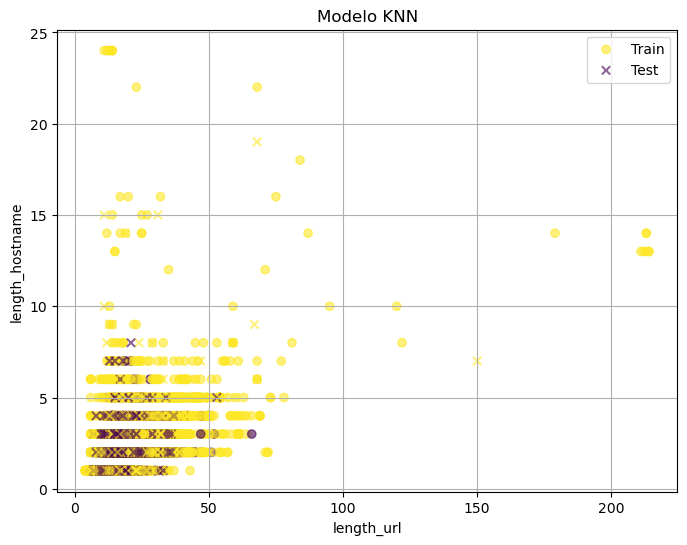

In [190]:
# Definicion de X_train, X_test, y_train, y_test están definidos como matrices de características
X_train = train_set.iloc[:, [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 57, 58, 59, 61, 63, 65, 68, 70, 71, 75, 82, 83]].values  # Seleccionar la característica deseada
y_train = train_set['status'].values  

X_test = test_set.iloc[:, [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 57, 58, 59, 61, 63, 65, 68, 70, 71, 75, 82, 83]].values  # Seleccionar la característica deseada del conjunto de prueba
y_test = test_set['status'].values 

# Inicializamos el modelo con K=3
knn = KNearestNeighbors(k=3)
knn.fit(X_train, y_train)

# Predicciones en el conjunto de test
y_pred = knn.predict(X_test)

# Evaluar métricas
tp, fp, fn, tn, sensitivity, specificity, accuracy = evaluate_metrics(y_test, y_pred)

# Resultados
print("\nMatriz de confusión:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")
print("------------------------------------------")
print("Sensibilidad: " , sensitivity*100, "%")
print("Especificidad: ", specificity*100, "%")
print("Precisión: ", accuracy*100, "%")

# Graficar los puntos de entrenamiento y test para dos variables 
plt.figure(figsize=(8, 6))
plt.scatter([x[1] for x in X_train], [x[2] for x in X_train], c=y_train, marker='o', label="Train", alpha=0.6) # Puntos de entrenamiento
plt.scatter([x[1] for x in X_test], [x[2] for x in X_test], c=y_pred, marker='x', label="Test", alpha=0.6) # Puntos de prueba
plt.title("Modelo KNN")
plt.xlabel("length_url")
plt.ylabel("length_hostname")
plt.legend()
plt.grid(True)
plt.show()


Por medio de ello, se puede definir que el modelo KNN tiene:<br>
- **Precisión:** 87.25% <br>
- **Sensibilidad:** 82.89% <br>
- **Especificidad:** 85.04% <br>

Los resultados del modelo KNN indican un buen desempeño, la precisión del 87.25% sugiere que el modelo es capaz de predecir correctamente la mayoría de los casos. La sensibilidad del 82.89% muestra que el modelo puede identificar correctamente un porcentaje significativo de los casos positivos, aunque hay un margen para mejorar en la detección de falsos negativos. Por otro lado, la especificidad del 85.04% es alta, lo que significa que el modelo es muy efectivo a la hora de identificar correctamente los casos negativos, reduciendo así los falsos positivos, en general, estos resultados son buenos.

---
Implementar el modelo usando **librerías**, para ello se importa scikit-learn. Con ello se puede generar un modelo y usar las mismas métricas de rendimiento para comparar con el modelo creado desde cero.


Matriz de confusión:
TP: 985, FP: 198
FN: 144, TN: 959
------------------------------------------
Precisión: 85.03937007874016 %
Sensibilidad:  87.24534986713907 %
Especificidad:  82.88677614520311 %


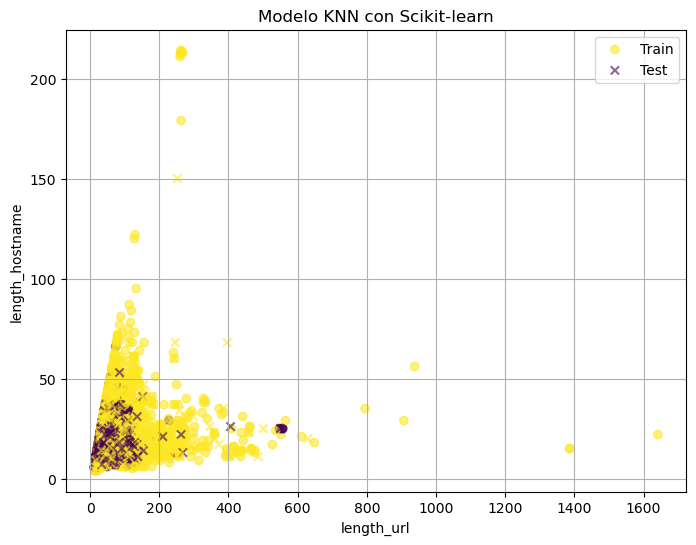

In [191]:
# Importar librerias 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Definición del dataset de entrenamiento y testeo
X_train = train_set.iloc[:, [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 57, 58, 59, 61, 63, 65, 68, 70, 71, 75, 82, 83]].values  
y_train = train_set['status'].values  

X_test = test_set.iloc[:, [1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 33, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 57, 58, 59, 61, 63, 65, 68, 70, 71, 75, 82, 83]].values  
y_test = test_set['status'].values  

# Inicialización del modelo de KNN con scikit-learn
knn_model = KNeighborsClassifier(n_neighbors=3)  # K = 3
knn_model.fit(X_train, y_train)  # Entrenamiento

# Predicciones
y_pred_sklearn = knn_model.predict(X_test)

# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_sklearn)
tp = conf_matrix[1, 1]  # Verdaderos positivos
fp = conf_matrix[0, 1]  # Falsos positivos
fn = conf_matrix[1, 0]  # Falsos negativos
tn = conf_matrix[0, 0]  # Verdaderos negativos

# Cálculo de métricas
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)  # Precisión
recall = tp / (tp + fn) if (tp + fn) != 0 else 0  # Sensibilidad 
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Especificidad

print("\nMatriz de confusión:")
print(f"TP: {tp}, FP: {fp}")
print(f"FN: {fn}, TN: {tn}")
print("------------------------------------------")
print("Precisión:" , accuracy_sklearn*100 , "%")
print("Sensibilidad: " , recall*100, "%")
print("Especificidad: " , specificity*100 , "%")

# Graficar resultados
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, marker='o', label="Train", alpha=0.6)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred_sklearn, marker='x', label="Test", alpha=0.6)
plt.title("Modelo KNN con Scikit-learn")
plt.xlabel("length_url")
plt.ylabel("length_hostname")
plt.legend()
plt.grid(True)
plt.show()


Por medio de ello, se puede definir que el modelo KNN con Scikit-learn tiene:<br>
- **Precisión:** 85.04% <br>
- **Sensibilidad:** 87.25% <br>
- **Especificidad:** 82.89% <br>

Ahora implementado con Scikit-learn muestran un desempeño bueno, la precisión del 85.04% indica que el modelo predice correctamente una gran proporción de los casos. La sensibilidad del 87.25% es alta, lo que significa que el modelo es efectivo para identificar los casos positivos, aunque podría mejorar ligeramente en la reducción de falsos negativos. Por otro lado, la especificidad del 82.89% es buena, pero ligeramente menor que la sensibilidad, lo que sugiere que el modelo podría tener un poco más de dificultad para distinguir entre casos negativos y falsos positivos.

---

**¿Cuál implementación fue mejor? ¿Por qué?**<br>

La primera implementación es mejor en términos de precisión general, lo que indica una mayor capacidad para predecir correctamente en general. Además, su especificidad es ligeramente superior, lo que sugiere una mejor capacidad para identificar correctamente los casos negativos. Por otro lado, la segunda implementación tiene una mejor sensibilidad, lo que significa que es más efectiva para detectar los casos positivos.Si se prioriza la precisión general y la capacidad para identificar casos negativos, la primera implementación es superior. Si se enfatiza la detección de casos positivos, la segunda podría ser más adecuada. Sin embargo, en términos generales, la primera implementación parece tener un desempeño ligeramente mejor debido a su mayor precisión.

---
### Link a Repositorio Github <br>
https://github.com/danielanavas2002/InteligenciaArtificial/tree/main/Laboratorio/Laboratorio01
